In [1]:
%matplotlib inline


================================================================
Permutation Importance vs Random Forest Feature Importance (MDI)
================================================================

In this example, we will compare the impurity-based feature importance of
:class:`~sklearn.ensemble.RandomForestClassifier` with the
permutation importance on the titanic dataset using
:func:`~sklearn.inspection.permutation_importance`. We will show that the
impurity-based feature importance can inflate the importance of numerical
features.

Furthermore, the impurity-based feature importance of random forests suffers
from being computed on statistics derived from the training dataset: the
importances can be high even for features that are not predictive of the target
variable, as long as the model has the capacity to use them to overfit.

This example shows how to use Permutation Importances as an alternative that
can mitigate those limitations.

.. topic:: References:

   [1] L. Breiman, "Random Forests", Machine Learning, 45(1), 5-32,
       2001. https://doi.org/10.1023/A:1010933404324


In [2]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

Automatically created module for IPython interactive environment


Data Loading and Feature Engineering
------------------------------------
Let's use pandas to load a copy of the titanic dataset. The following shows
how to apply separate preprocessing on numerical and categorical features.

We further include two random variables that are not correlated in any way
with the target variable (``survived``):

- ``random_num`` is a high cardinality numerical variable (as many unique
  values as records).
- ``random_cat`` is a low cardinality categorical variable (3 possible
  values).



In [3]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'par

Accuracy of the Model
---------------------
Prior to inspecting the feature importances, it is important to check that
the model predictive performance is high enough. Indeed there would be little
interest of inspecting the important features of a non-predictive model.

Here one can observe that the train accuracy is very high (the forest model
has enough capacity to completely memorize the training set) but it can still
generalize well enough to the test set thanks to the built-in bagging of
random forests.

It might be possible to trade some accuracy on the training set for a
slightly better accuracy on the test set by limiting the capacity of the
trees (for instance by setting ``min_samples_leaf=5`` or
``min_samples_leaf=10``) so as to limit overfitting while not introducing too
much underfitting.

However let's keep our high capacity random forest model for now so as to
illustrate some pitfalls with feature importance on variables with many
unique values.



In [4]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.817


Tree's Feature Importance from Mean Decrease in Impurity (MDI)
--------------------------------------------------------------
The impurity-based feature importance ranks the numerical features to be the
most important features. As a result, the non-predictive ``random_num``
variable is ranked the most important!

This problem stems from two limitations of impurity-based feature
importances:

- impurity-based importances are biased towards high cardinality features;
- impurity-based importances are computed on training set statistics and
  therefore do not reflect the ability of feature to be useful to make
  predictions that generalize to the test set (when the model has enough
  capacity).



/Users/rp_mbp/.pyenv/versions/3.7.4/envs/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


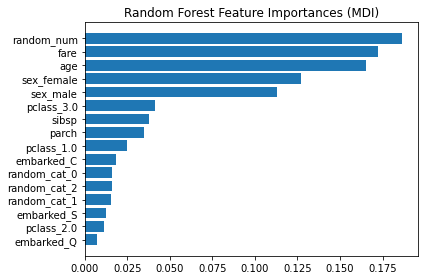

In [5]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

As an alternative, the permutation importances of ``rf`` are computed on a
held out test set. This shows that the low cardinality categorical feature,
``sex`` is the most important feature.

Also note that both random features have very low importances (close to 0) as
expected.



In [8]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

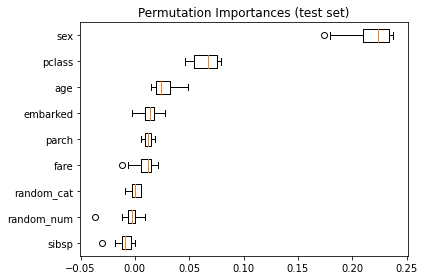

In [6]:
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

It is also possible to compute the permutation importances on the training
set. This reveals that ``random_num`` gets a significantly higher importance
ranking than when computed on the test set. The difference between those two
plots is a confirmation that the RF model has enough capacity to use that
random numerical feature to overfit. You can further confirm this by
re-running this example with constrained RF with min_samples_leaf=10.



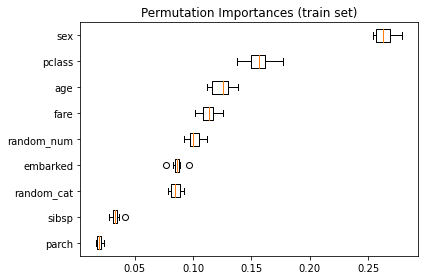

In [7]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()